In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PMF.algorithm import *
%matplotlib inline

Below we have a regularized/hierarchical Poisson matrix factorization. Priors are from two gamma distributions, and the likelihood is of Poisson form. Note this connects to the original NMF (Lee & Seung 2001) in that if it were not regularized, then it would have been the same as the original NMF divergence update case. This is because log Poisson likelihood has the same optimizer as the generalized KL divergence. 

Note here we use a nice initialization. We do the random column initialization as given in Langville 2014. This gives a very nice head start to our problem.

In [5]:
ratings = pd.read_csv('movielens/ratings.csv')
ratings = ratings.values
ratings[:,:2] -= 1
ratings = ratings[:,:-1]
n_obs = ratings.shape[0]

In [6]:
m,n = int(ratings[:,0].max()+1),int(ratings[:,1].max()+1)
n_obs = len(ratings[:,0])
X_obs = np.zeros((m,n))
Mask = np.zeros((m,n))

shuffled_m = list(range(m))
np.random.shuffle(shuffled_m)
shuffled_n = list(range(n))
np.random.shuffle(shuffled_n)
shuffled_ij_obs = list(range(n_obs))
np.random.shuffle(shuffled_ij_obs)

div = int(n_obs*9/10)
X_train = ratings[shuffled_ij_obs[:div],:3]
X_test = ratings[shuffled_ij_obs[div:],:3]

In [7]:
#%debug
r0,r1,r2 = Poisson_pmf(X_train,(m,n),20,T=50,full=True,verbose=True)

=======  0 =======
speed break down: 

U_update: 	0.04660797119140625s
V_update: 	0.0845639705657959s
log posterior: 	0.011806964874267578s
log posterior:
1603.4535092344734
=======  1 =======
speed break down: 

U_update: 	0.029421091079711914s
V_update: 	0.08667802810668945s
log posterior: 	0.011291027069091797s
log posterior:
68027.51481475425
=======  2 =======
speed break down: 

U_update: 	0.03153705596923828s
V_update: 	0.09567403793334961s
log posterior: 	0.013453006744384766s
log posterior:
80669.89837029968
=======  3 =======
speed break down: 

U_update: 	0.03129982948303223s
V_update: 	0.08671212196350098s
log posterior: 	0.010947942733764648s
log posterior:
84238.2079300473
=======  4 =======
speed break down: 

U_update: 	0.0298309326171875s
V_update: 	0.09264492988586426s
log posterior: 	0.010923147201538086s
log posterior:
85464.10906011835
=======  5 =======
speed break down: 

U_update: 	0.030787944793701172s
V_update: 	0.09236311912536621s
log posterior: 	0.010517835

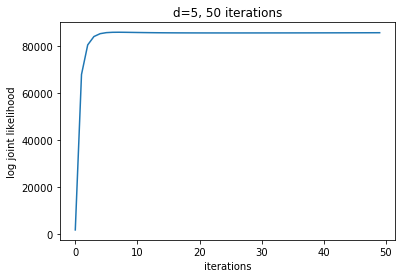

In [8]:
plt.plot(r2[:50])
plt.title('d=5, 50 iterations')
plt.ylabel('log joint likelihood')
plt.xlabel('iterations')
plt.show()

In [13]:
rank_list = [1,2,3,5,8,10,15,20]
log_post_list = []
out_U = []
out_V = []
runtime = []
for r in rank_list:
    start_time = tm.time()
    U,V,log_P = Poisson_pmf(X_train,(m,n),r,T=1000,full=True)
    end_time = tm.time()
    runtime.append(end_time-start_time)
    out_U.append(U)
    out_V.append(V)
    log_post_list.append(log_P)
    print("for rank = " +str(r)+ ", it took "+str(runtime[-1])+'s')

for rank = 1, it took 66.0564079284668s
for rank = 2, it took 84.2432119846344s
for rank = 3, it took 95.30798101425171s
for rank = 5, it took 108.71617889404297s
for rank = 8, it took 126.07658195495605s
for rank = 10, it took 139.52126789093018s
for rank = 15, it took 171.54186010360718s
for rank = 20, it took 205.0762140750885s


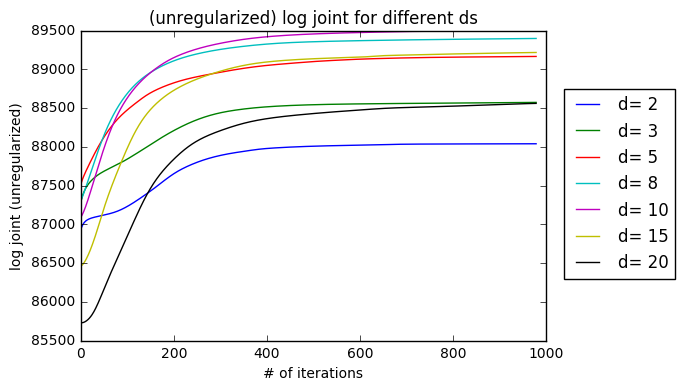

In [14]:
for (i,r) in enumerate(rank_list[:]):
    if r >1:
        plt.plot(log_post_list[i][20:],label='d= '+str(r))
plt.ylabel('log joint (unregularized)')
plt.xlabel('# of iterations')
plt.legend(loc=[1.04,0.2])
plt.title('(unregularized) log joint for different ds')
plt.show()
    

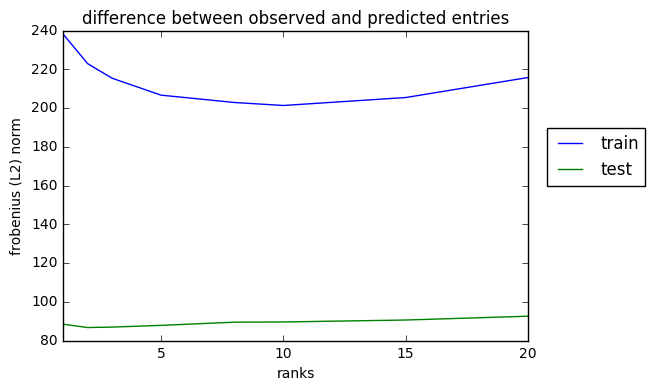

In [15]:
pred_diff = []
pred_percentage = []
train_diff = []
train_percentage = []
for i in range(len(rank_list)):
    p0,p1 = predict(X_test,out_U[i],out_V[i])
    p2,p3 = predict(X_train,out_U[i],out_V[i])
    pred_diff.append(p0)
    pred_percentage.append(p1)
    train_diff.append(p2)
    train_percentage.append(p3)

plt.plot(rank_list,train_diff,label='train')
plt.plot(rank_list,pred_diff,label='test')
plt.title('difference between observed and predicted entries')
plt.legend(loc=[1.04,0.5])
plt.ylabel('frobenius (L2) norm')
plt.xlabel('ranks')
plt.xlim([min(rank_list),max(rank_list)])
plt.show()

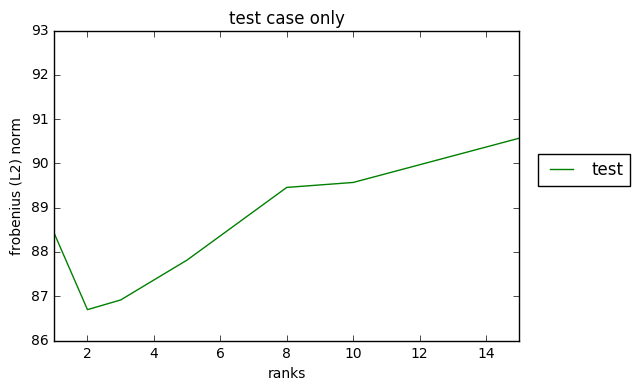

In [16]:
plt.plot(rank_list,pred_diff,label='test', color='g')
plt.title('test case only')
plt.legend(loc=[1.04,0.5])
plt.ylabel('frobenius (L2) norm')
plt.xlabel('ranks')
plt.xlim([1,15])
plt.show()